In [48]:
# AMI Examples

import pandas as pd
import xarray as xr
import h5py 
import os

# Put AMI data from London

def get_climate(city_name):
    '''
    get climate data (closest EPW weather file) based on city location
    City location based on about 7000 cities in the world (https://simplemaps.com/data/world-cities) or Nominatim()
    '''
    
    import pandas as pd
    import os
    from geopy.geocoders import Nominatim
    from geopy.distance import geodesic

    geolocator = Nominatim(user_agent="home-energy")
    
    cities = pd.read_csv(os.path.join('data','location-data','simplemaps-worldcities-basic.csv'))
    cities['loc'] = cities['city'] + ', ' + cities['country']
    cities = cities.sort_values('pop',ascending=False)

    if city_name in cities['city'].values:
        if len(cities[cities['city']==city_name]['lat'].values) == 1:
            lat,lon = float(cities[cities['city']==city_name]['lat'].values), float(cities[cities['city']==city_name]['lng'].values)
        else:
            lat,lon = float(cities[cities['city']==city_name]['lat'].values[0]), float(cities[cities['city']==city_name]['lng'].values[0])
            
        city = city_name
    
    else:
        # Note that this option tends to be quite slow (~1.5s), so reserved for cases when city name can't be found.
        location = geolocator.geocode(city_name,addressdetails=True)
        lat,lon = location.latitude, location.longitude
        city = location.raw['address']['city']

    df = pd.read_csv(os.path.join('data','weather','designconditions','epwlist.csv'))
    df['Distance'] = df.apply(lambda x: geodesic((x['lat'], x['lon']),(lat,lon)).kilometers, axis=1)
    ID = df['Distance'].idxmin()
    
    return df.loc[ID]

def processLondonData():
    '''
    Sample AMI data from London (~5000 households, from 2011~2014)
    Source: https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households
    '''
    
    files = ['block_%d.csv'% i for i in range(112)]
    hdf5_file = os.path.join('data','utility','samples','London','halfhourly_dataset.h5')

    for f in files:

        file_path = os.path.join('data','utility','samples','London','halfhourly_dataset',f)
        df = pd.read_csv(file_path,low_memory=False)
        df['tstp'] = pd.to_datetime(df['tstp'])
        df['energy(kWh/hh)'] = pd.to_numeric(df['energy(kWh/hh)'],errors = 'coerce').astype('float16')

        keys = df['LCLid'].unique()
        df = df.set_index(['LCLid','tstp'])

        # Store in HDF5 format with LCLid as key
        for key in keys:
            df.loc[key].to_hdf(hdf5_file, key=key, mode='a', format='fixed',complevel = 1)    
            
    return None

# Weather data
def get_weather_data(lat,lon,country,param,year):
    
    # Find chunk size
    data = xr.open_dataset(os.path.join('data','weather',country,'%s_%d.nc'%(param,year)))
    lat_chunks = len(data.lat)
    lon_chunks = len(data.lon)
    
    data = xr.open_dataset(os.path.join('data','weather',country,'%s_%d.nc'%(param,year)),chunks={'lat':lat_chunks, 'lon':lon_chunks})

    data = data.sel(lat=lat,lon=lon,method='nearest') - 273.15

    return data

In [64]:
climate = get_climate('New York')

In [65]:
soil =  get_weather_data(climate['lat'],climate['lon'],'US','soil_temperature_level_4',2010)

In [66]:
soil.var236 * 100

<xarray.DataArray 'var236' (time: 8760)>
dask.array<shape=(8760,), dtype=float32, chunksize=(8760,)>
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 2010-01-01T01:00:00 ...
    lon      float32 234.5
    lat      float32 40.75

In [90]:
%timeit t2m, soil = get_weather_data('Brisbane','AU')

632 ms ± 9.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [80]:
import datetime as dt
start = dt.datetime(year = 2010, month = 1, day = 1)
end = dt.datetime(year = 2011, month = 1, day = 1)

year = soil.sel(time=slice(start, end))

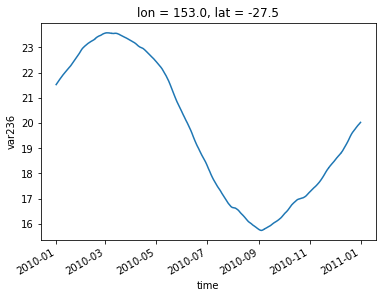

In [76]:
year.var236.plot()

In [4]:
hdf5_file = os.path.join('data','utility','samples','London','halfhourly_dataset.h5')
f = h5py.File(hdf5_file,'r')
keys = list(f.keys())

In [5]:
len(keys)

5566

In [29]:
from tqdm import tqdm

data = {}

for i in tqdm(range(50)):
    
    df = pd.read_hdf(hdf5_file,key = keys[i])
    monthly = df.groupby(df.index.month).mean()
    weekday = df[(df.index.weekday <= 4)&(df.index.month == 1)]
    hourly = weekday.groupby(weekday.index.hour).mean()
    weekday = df[(df.index.weekday <= 4)&(df.index.month == 7)]
    data[keys[i]] = weekday.groupby(weekday.index.hour).mean()['energy(kWh/hh)']

100%|██████████| 50/50 [00:01<00:00, 49.94it/s]


In [21]:
df = pd.DataFrame(data) 
normalized_df=(df-df.mean())/df.std()
#normalized_df=(df-df.min())/(df.max()-df.min())

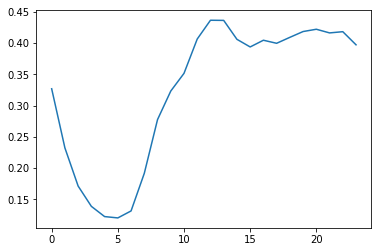

In [36]:
plt.plot(df.groupby(df.index.hour).mean())
plt.show()

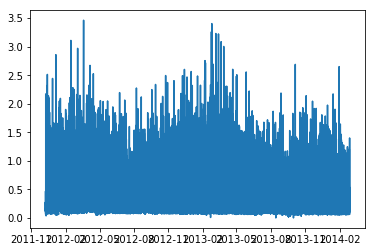

In [26]:
plt.plot(df)

/home/joseph/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


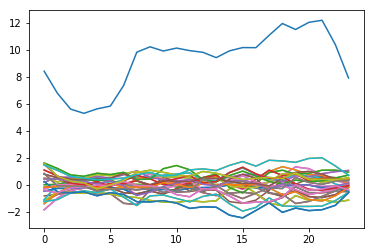

In [17]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.fft.fft(df))
#plt.plot(df)

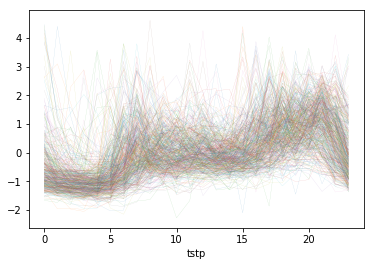

In [65]:
normalized_df.loc[:,'MAC000002':'MAC000490'].plot(legend=None,alpha = 0.3,linewidth=0.2)

In [140]:
df = pd.read_csv(os.path.join('data','weather','designconditions','epwlist.csv'))

In [143]:
df['lat2'] = df['lat'].astype(int)
df['lon2'] = df['lon'].astype(int)

In [145]:
df['latlon'] = df['lat2'].astype(str) + df['lon2'].astype(str)

In [149]:
len(df)

2019

In [200]:
df

,energy(kWh/hh)
tstp,
2012-10-22 11:00:00,0.379883
2012-10-22 11:30:00,0.245972
2012-10-22 12:00:00,0.428955
2012-10-22 12:30:00,0.405029
2012-10-22 13:00:00,0.500000
2012-10-22 13:30:00,0.674805
2012-10-22 14:00:00,0.563965
2012-10-22 14:30:00,1.171875
2012-10-22 15:00:00,0.339111
